In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=(-90, 90)),
                                        transforms.ToTensor()])


test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

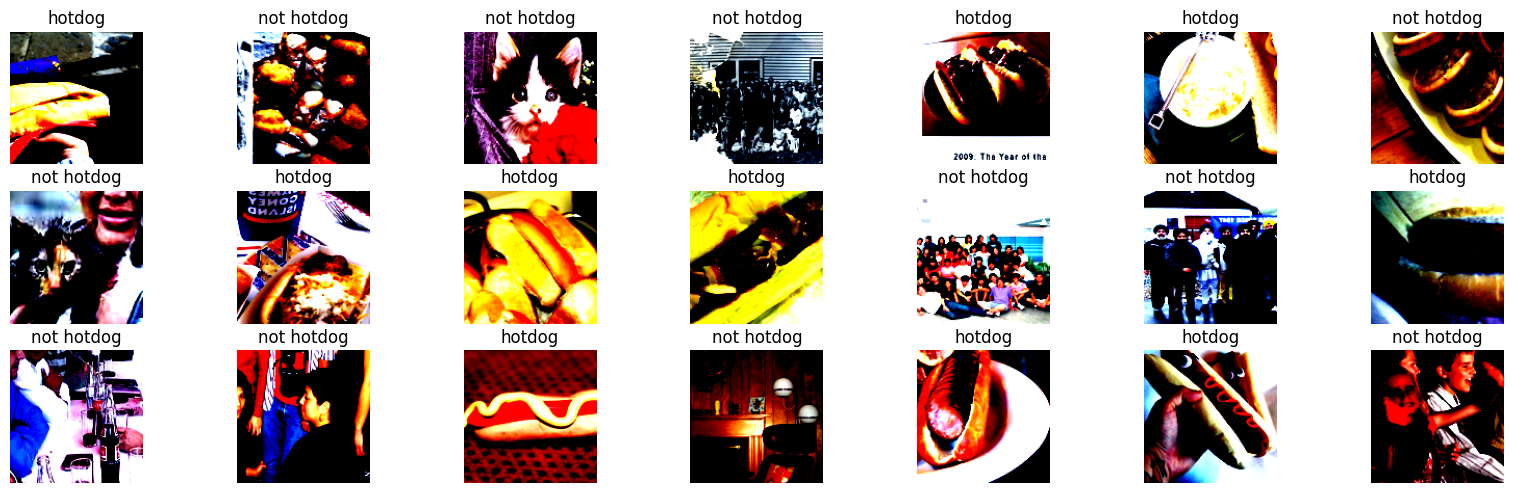

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [7]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target) 
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = nn.CrossEntropyLoss()(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [8]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = torch.optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.01)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
out_dict = train(model_ft, optimizer_adam, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.281	 test: nan	 Accuracy train: 87.4%	 test: 93.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.165	 test: nan	 Accuracy train: 93.4%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.141	 test: nan	 Accuracy train: 94.5%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.129	 test: nan	 Accuracy train: 94.8%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.089	 test: nan	 Accuracy train: 96.9%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.108	 test: nan	 Accuracy train: 95.6%	 test: 90.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.101	 test: nan	 Accuracy train: 96.3%	 test: 90.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.089	 test: nan	 Accuracy train: 97.1%	 test: 91.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.100	 test: nan	 Accuracy train: 96.1%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.105	 test: nan	 Accuracy train: 95.6%	 test: 92.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.114	 test: nan	 Accuracy train: 95.7%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.095	 test: nan	 Accuracy train: 96.8%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.104	 test: nan	 Accuracy train: 96.1%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.102	 test: nan	 Accuracy train: 96.6%	 test: 90.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.110	 test: nan	 Accuracy train: 95.5%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: nan	 Accuracy train: 96.1%	 test: 87.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: nan	 Accuracy train: 96.2%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.098	 test: nan	 Accuracy train: 96.3%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.119	 test: nan	 Accuracy train: 95.1%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.096	 test: nan	 Accuracy train: 96.6%	 test: 91.4%


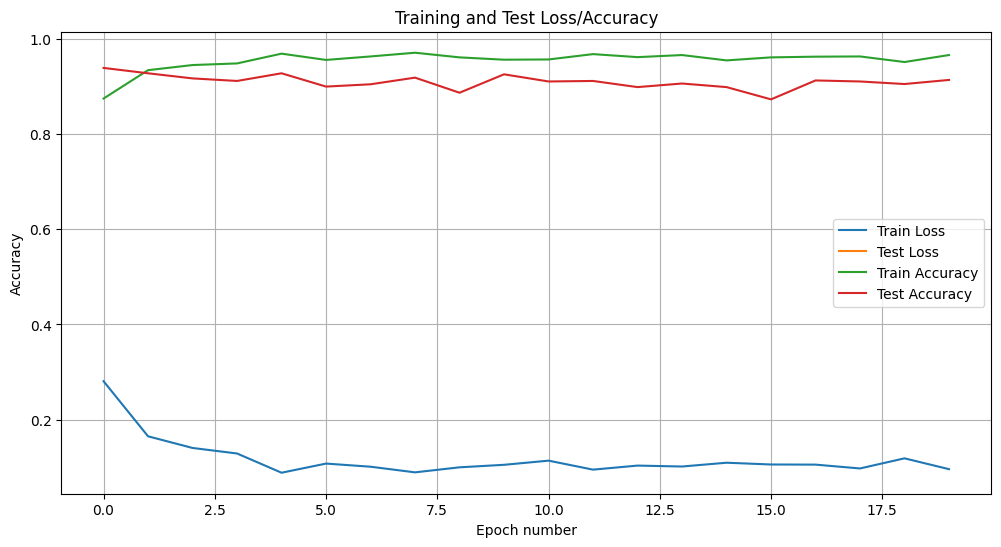

In [10]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.plot(out_dict['train_loss'], label='Train Loss')
plt.plot(out_dict['test_loss'], label='Test Loss')

# Plot Accuracy
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')

plt.title('Training and Test Loss/Accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

# Add legends
plt.legend()

plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 1:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.9969674  0.00303259]]


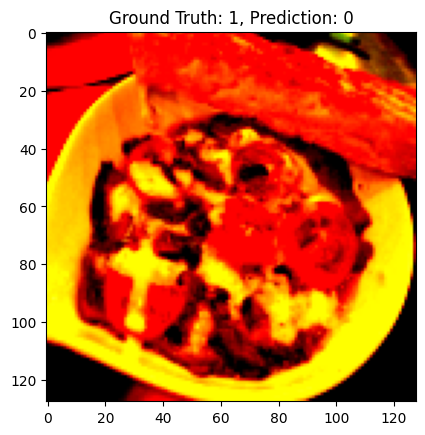

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 3:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.99670607 0.00329392]]


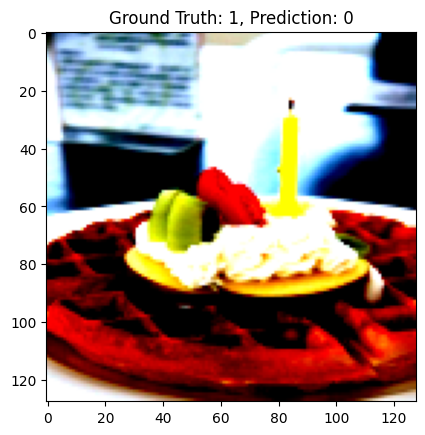

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 7:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.95267063 0.04732931]]


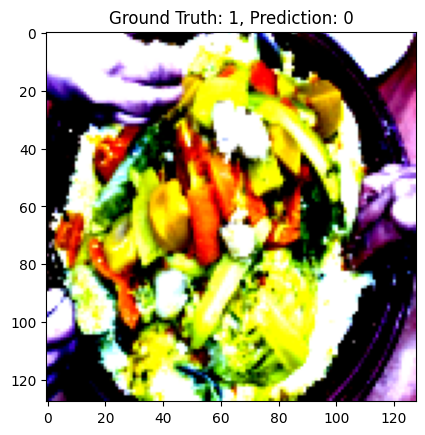

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 10:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.9939262  0.00607383]]


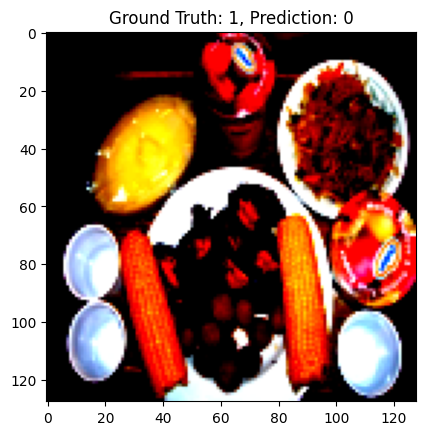

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 14:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.9751355  0.02486455]]


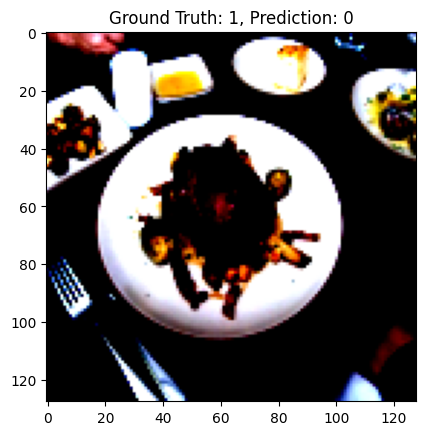


Misclassified Example 17:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.8745163  0.12548368]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


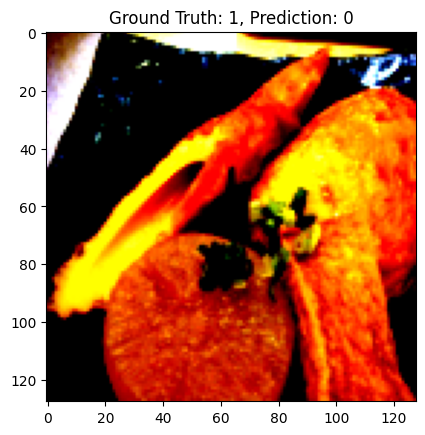

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 23:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.7796584  0.22034158]]


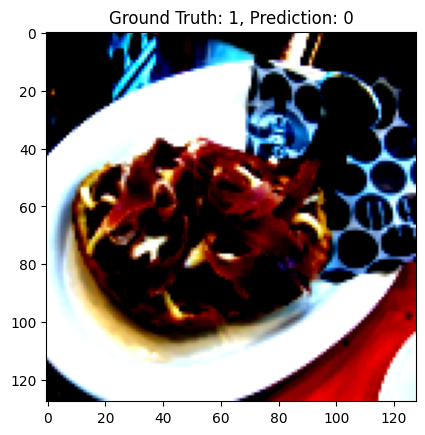

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 24:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.7157485  0.28425154]]


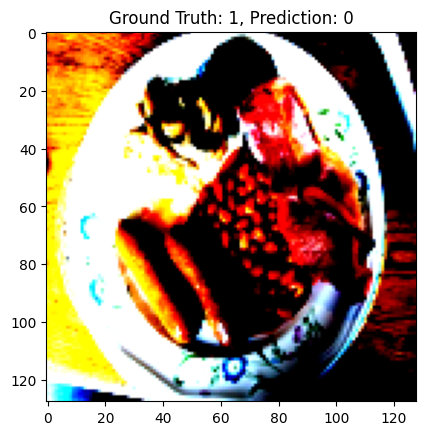

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 31:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.99569076 0.00430925]]


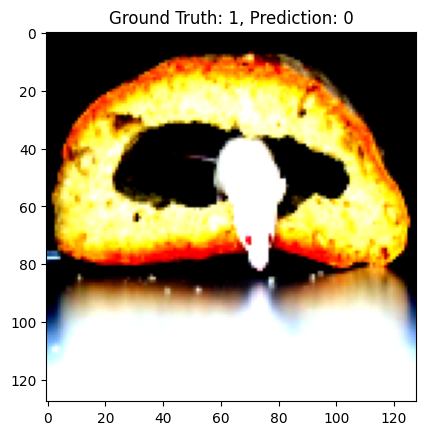

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Misclassified Example 36:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.94106686 0.05893314]]


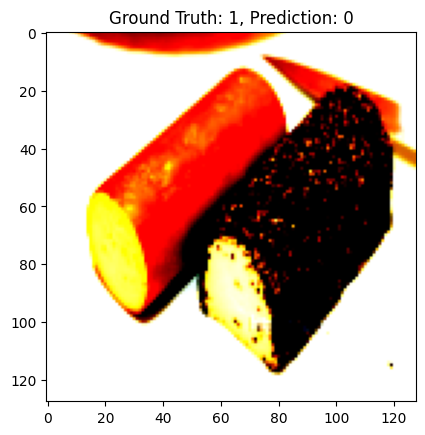

In [11]:
c = 0
with torch.no_grad():
    for i in range(len(test_loader.dataset)):
        example_data, example_target = test_loader.dataset[i+int(len(test_loader.dataset)/2)]
        example_data = example_data.unsqueeze(0).to(device)  # Add batch dimension
        example_output = model_ft(example_data)

        if example_target != example_output.argmax().item():
            c += 1
            print(f"\nMisclassified Example {i + 1}:")
            print("Ground Truth:", example_target)
            print("Model Prediction:", example_output.argmax().item())
            print("Model Probabilities:", torch.softmax(example_output, dim=1).cpu().numpy())

            # Display the associated MNIST image
            plt.imshow(example_data.squeeze().permute(1, 2, 0).cpu().numpy())
            plt.title(f"Ground Truth: {example_target}, Prediction: {example_output.argmax().item()}")
            plt.show()
        if c > 9:
            break

In [28]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = train_transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    input = input.to(device)
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = input[0]
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [29]:
images, labels = next(iter(train_loader))
saliency_tranform = transforms.ToPILImage()
img = saliency_tranform(images[0])
saliency(img, model_ft)


/tmp/ipykernel_21035/3960311927.py:22: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)


TypeError: 'NoneType' object is not subscriptable

In [17]:
images[0]

tensor([[[-0.6623, -0.6794, -0.6623,  ..., -0.2342, -0.5424, -0.8335],
         [-0.6623, -0.6452, -0.6623,  ..., -0.2342, -0.3883, -0.5767],
         [-0.6452, -0.6452, -0.6623,  ..., -0.0116,  0.1939,  0.2111],
         ...,
         [-1.7240, -1.7240, -1.7412,  ..., -1.5528, -1.5870, -1.5699],
         [-1.7069, -1.7240, -1.7412,  ..., -1.5699, -1.6042, -1.6042],
         [-1.6898, -1.7069, -1.7240,  ..., -1.6213, -1.6384, -1.6555]],

        [[-0.4776, -0.5126, -0.5301,  ..., -0.8277, -1.0903, -1.3880],
         [-0.4776, -0.4776, -0.5301,  ..., -0.9328, -1.0728, -1.2654],
         [-0.4601, -0.4776, -0.5126,  ..., -0.8277, -0.6702, -0.7052],
         ...,
         [-1.6681, -1.6681, -1.6856,  ..., -1.6155, -1.6506, -1.6331],
         [-1.6506, -1.6681, -1.6856,  ..., -1.6331, -1.6681, -1.6681],
         [-1.6331, -1.6506, -1.6681,  ..., -1.6856, -1.7031, -1.7206]],

        [[-0.0964, -0.0964, -0.0964,  ..., -1.2467, -1.4036, -1.6302],
         [-0.0615, -0.0615, -0.0790,  ..., -1